In [1]:
from astropy.time import Time, TimeDelta
import astropy.units as u
import glob
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import numpy as np
import os
import pandas as pd
import sunpy.coordinates.sun as sn
import scipy.ndimage as ndi
import scipy.stats as st
# Our own library for using spice with STEREO (https://github.com/LukeBarnard/stereo_spice)
from stereo_spice.coordinates import StereoSpice
# Local packages
import HUXt as H

spice = StereoSpice()


In [2]:
def setup_huxt(start_time, uniform_wind=True):
    """
    Initialise HUXt with some predetermined boundary/initial conditions
    start_time should be astropy.Time object.
    uniform_wind is flag for setting uniform 400km/s wind.
    """
    cr_num = np.fix(sn.carrington_rotation_number(start_time))
    ert = H.Observer('EARTH', start_time)

    # Set up HUXt for a 5 day simulation with homogenous inner boundary.
    vr_in, br_in = H.Hin.get_MAS_long_profile(cr_num, ert.lat.to(u.deg))
    if uniform_wind:
        vr_in = np.zeros(vr_in.shape) + 400*vr_in.unit
        
    model = H.HUXt(v_boundary=vr_in, cr_num=cr_num, cr_lon_init=ert.lon_c, latitude=ert.lat.to(u.deg),
                   br_boundary=br_in, lon_start=270*u.deg, lon_stop=90*u.deg, simtime=3.5*u.day, dt_scale=4)
    
    return model

def get_base_cme(v=1000, lon=0, lat=0, width=35, thickness=1):
    """
    Return the base CME, which is used to establish the pseudo-truth CME and the SIR ensemble
    """
    t_launch = (1*u.hr).to(u.s)
    cme = H.ConeCME(t_launch=t_launch, longitude=lon*u.deg, latitude=lat*u.deg, width=width*u.deg, v=v*(u.km/u.s), thickness=thickness*u.solRad)
    return cme

def perturb_cone_cme(cme):
    """
    Perturb a ConeCME's parameters. Used to establish the pseudo-truth CME and the initial SIR ensemble members. 
    """
    lon_spread = 10*u.deg
    lat_spread = 10*u.deg
    width_spread = 10*u.deg
    v_spread = 100*(u.km/u.s)
    thickness_spread = 1*u.solRad
    
    randoms = np.random.uniform(-1,1,5)
    lon_new = cme.longitude + randoms[0]*lon_spread
    lat_new = cme.latitude + randoms[1]*lat_spread
    width_new = cme.width + randoms[2]*width_spread
    v_new = cme.v + randoms[3]*v_spread
    thickness_new = cme.thickness + randoms[4]*thickness_spread
    
    cme_perturb = H.ConeCME(t_launch=cme.t_launch,
                            longitude=lon_new,
                            latitude=lat_new,
                            width=width_new,
                            v=v_new,
                            thickness=thickness_new)
    return cme_perturb

def compute_profile_difference(obs_flank, model_flank):
    """
    Compute the rms difference between the observed and modelled flank elongations. 
    """
    # Do interp rather than join of dataframes, as it generalises out of model world. 
    elon_interp = np.interp(obs_flank['time'].values, model_flank['time'].values, model_flank['el'].values, left=np.NaN, right=np.NaN)
    matched_model = pd.DataFrame({'time': obs_flank['time'].values, 'el': elon_interp})
    de = (matched_model['el'] - obs_flank['el'])**2
    n_rms_samp = np.sum(np.isfinite(de))
    rms = np.sqrt(de.mean(skipna=True))
    return rms, n_rms_samp

class Observer:
    
    @u.quantity_input(longitude=u.deg)
    def __init__(self, model, longitude, el_min=4.0, el_max=30.0):
        
        ert_ephem = model.get_observer('EARTH')
        
        self.time = ert_ephem.time 
        self.r = ert_ephem.r
        self.lon = ert_ephem.lon + longitude
        self.lat = ert_ephem.lat
        self.el_min = el_min
        self.el_max = el_max
        # Force longitude into 0-360 domain
        id_over = self.lon > 360*u.deg
        id_under = self.lon < 0*u.deg
        if np.any(id_over):
            self.lon[id_over] = self.lon[id_over] - 360*u.deg
        if np.any(id_under):
            self.lon[id_under] = self.lon[id_under] + 360*u.deg
        
        cme = model.cmes[0]
        self.model_flank = self.compute_flank_profile(cme)
        
    def compute_flank_profile(self, cme):
        """
        Compute the time elongation profile of the flank of a ConeCME in HUXt. The observer longtidue is specified relative to Earth,
        and but otherwise matches Earth's coords. 

        Parameters
        ----------
        observer_lon: Angular separation of Earth and the observer, in HEEQ.
        cme: A ConeCME object from a completed HUXt run (i.e the ConeCME.coords dictionary has been populated).
        Returns
        -------
        obs_profile: Pandas dataframe giving the coordinates of the ConeCME flank from STA's perspective, including the
                    time, elongation, position angle, and HEEQ radius and longitude.
        """
        times = Time([coord['time'] for i, coord in cme.coords.items()])

        # Compute observers location using earth ephem, adding on observers longitude offset from Earth and correct for runover 2*pi
        flank = pd.DataFrame(index=np.arange(times.size), columns=['time', 'el', 'r', 'lon'])
        flank['time'] = times.jd

        for i, coord in cme.coords.items():

            if len(coord['r']) == 0:
                flank.loc[i, ['lon','r', 'el']] = np.NaN
                continue

            r_obs = self.r[i]
            x_obs = self.r[i] * np.cos(self.lat[i]) * np.cos(self.lon[i])
            y_obs = self.r[i] * np.cos(self.lat[i]) * np.sin(self.lon[i])
            z_obs = self.r[i] * np.sin(self.lat[i])

            lon_cme = coord['lon']
            lat_cme = coord['lat']
            r_cme = coord['r']

            x_cme = r_cme * np.cos(lat_cme) * np.cos(lon_cme)
            y_cme = r_cme * np.cos(lat_cme) * np.sin(lon_cme)
            z_cme = r_cme * np.sin(lat_cme)
            #############
            # Compute the observer CME distance, S, and elongation

            x_cme_s = x_cme - x_obs
            y_cme_s = y_cme - y_obs
            z_cme_s = z_cme - z_obs
            s = np.sqrt(x_cme_s**2 + y_cme_s**2 + z_cme_s**2)

            numer = (r_obs**2 + s**2 - r_cme**2).value
            denom = (2.0 * r_obs * s).value
            e_obs = np.arccos(numer / denom)

            # Find the flank coordinate and update output
            id_obs_flank = np.argmax(e_obs)       
            flank.loc[i, 'lon'] = lon_cme[id_obs_flank].value
            flank.loc[i, 'r'] = r_cme[id_obs_flank].value
            flank.loc[i, 'el'] = np.rad2deg(e_obs[id_obs_flank])

        # Force values to be floats.
        keys = ['lon', 'r', 'el']
        flank[keys] = flank[keys].astype(np.float64)
        return flank
    
    def compute_synthetic_obs(self, el_spread=0.5, cadence=5, el_min=4.0, el_max=30.0):
        """
        Return synthetic observations with a specified uncertainty spread, cadence, and maximum elongation.
        el_spread = standard deviation of random gaussian noise added to the modelled elongation.
        cadence = The cadence with witch observations are returned, as a whole number of model time steps.
        el_min = The minimum elongation of the observers field of view.
        el_max = The maximum elongation of the observers field of view.
        """

        # Compute the time-elongation profiles of the CME flanks from STA and STB
        model_flank = self.model_flank.copy()

        # Remove invalid points
        model_flank.dropna(inplace=True)

        # Add observation noise.
        obs_flank = model_flank.loc[:, ['time', 'el']].copy()
        obs_flank['el'] = obs_flank['el'] + el_spread*np.random.randn(obs_flank.shape[0])

        # Only keep every dt_scale'th observation and reindex - dt_scale=5 corrsponds to ~2hr
        obs_flank = obs_flank[::cadence]
        obs_flank.set_index(np.arange(0, obs_flank.shape[0]), inplace=True)

        # Only return up to el_max ~ (approx HI1 FOV is 25deg)
        id_fov = (obs_flank['el'] >= el_min) & (obs_flank['el'] <= el_max)
        obs_flank = obs_flank[id_fov]
        return obs_flank

def get_cme_params(cme):
    """
    Form an array of the CME parameter values that are kept track of in the ensemble members.
    """
    params = np.array([cme.longitude.to('rad').value, cme.latitude.to('rad').value,
                       cme.width.to('rad').value, cme.thickness.to('km').value, cme.v.value])
    
    return params

def create_analysis_output_file(filename):
    """
    Create a HDF5 file for storing the SIR analysis steps.
    """
    proj_dirs = H._setup_dirs_()
    out_filepath = os.path.join(proj_dirs['out_data'], filename)
    if os.path.isfile(out_filepath):
        # File exists, so delete and start new.
        print("Warning: {} already exists. Overwriting".format(out_filepath))
        os.remove(out_filepath)

    out_file = h5py.File(out_filepath, 'w')
    return out_file

def plot_huxt_with_observer(time, model, observer, add_flank=False, add_fov=False):
    
    id_t = np.argmin(np.abs(model.time_out - time))

    # Get plotting data
    lon_arr, dlon, nlon = H.longitude_grid()
    lon, rad = np.meshgrid(lon_arr.value, model.r.value)
    mymap = mpl.cm.viridis
    v_sub = model.v_grid_cme.value[id_t, :, :].copy()
    # Insert into full array
    if lon_arr.size != model.lon.size:
        v = np.zeros((model.nr, nlon)) * np.NaN
        if model.lon.size != 1:
            for i, lo in enumerate(model.lon):
                id_match = np.argwhere(lon_arr == lo)[0][0]
                v[:, id_match] = v_sub[:, i]
        else:
            print('Warning: Trying to contour single radial solution will fail.')
    else:
        v = v_sub

    # Pad out to fill the full 2pi of contouring
    pad = lon[:, 0].reshape((lon.shape[0], 1)) + model.twopi
    lon = np.concatenate((lon, pad), axis=1)
    pad = rad[:, 0].reshape((rad.shape[0], 1))
    rad = np.concatenate((rad, pad), axis=1)
    pad = v[:, 0].reshape((v.shape[0], 1))
    v = np.concatenate((v, pad), axis=1)

    mymap.set_over('lightgrey')
    mymap.set_under([0, 0, 0])
    levels = np.arange(200, 800 + 10, 10)
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "polar"})
    cnt = ax.contourf(lon, rad, v, levels=levels, cmap=mymap, extend='both')

    # Add on CME boundaries and Observer
    cme = model.cmes[0]
    ax.plot(cme.coords[id_t]['lon'], cme.coords[id_t]['r'], '-', color='darkorange', linewidth=3, zorder=3)
    ert = model.get_observer('EARTH')
    ax.plot(ert.lon[id_t], ert.r[id_t], 'co', markersize=16, label='Earth')            

    # Add on the observer
    ax.plot(observer.lon[id_t], observer.r[id_t], 's', color='r', markersize=16, label='Observer')
        
    if add_flank:
        flank_lon = observer.model_flank.loc[id_t,'lon']
        flank_rad = observer.model_flank.loc[id_t,'r']
        ax.plot(flank_lon, flank_rad, 'r.', markersize=10, zorder=4)
        # Add observer-flank line
        ro = observer.r[id_t]
        lo = observer.lon[id_t]
        ax.plot([lo.value, flank_lon], [ro.value, flank_rad], 'r--', zorder=4)
        
    if add_fov:
        flank_lon = observer.model_flank.loc[id_t,'lon']
        flank_rad = observer.model_flank.loc[id_t,'r']
        fov_patch = get_fov_patch(observer.r[id_t], observer.lon[id_t], observer.el_min, observer.el_max)
        ax.add_patch(fov_patch)

    ax.set_ylim(0, 240)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.patch.set_facecolor('slategrey')

    fig.subplots_adjust(left=0.05, bottom=0.16, right=0.95, top=0.99)
    # Add color bar
    pos = ax.get_position()
    dw = 0.005
    dh = 0.045
    left = pos.x0 + dw
    bottom = pos.y0 - dh
    wid = pos.width - 2 * dw
    cbaxes = fig.add_axes([left, bottom, wid, 0.03])
    cbar1 = fig.colorbar(cnt, cax=cbaxes, orientation='horizontal')
    cbar1.set_label('Solar Wind speed (km/s)')
    cbar1.set_ticks(np.arange(200, 810, 100))
    return fig, ax

def get_fov_patch(ro, lo, el_min, el_max):
    """
    Function to compute a matplotlib patch to higlight an observers field of view. 
    ro = radius of observer (in solRad)
    lo = longitude of observer (in rad)
    el_min = minimum elongation of the field of view
    el_max = maximum elongation of the field of view
    """
    xo = ro*np.cos(lo)
    yo = ro*np.sin(lo)
    
    fov_patch =[[lo.value, ro.value]]
    
    for el in [el_min, el_max]:

        rp = ro*np.tan(el*u.deg)
        if (lo < 0*u.rad) | (lo > np.pi*u.rad):
            lp = lo + 90*u.deg
        else:
            lp = lo - 90*u.deg

        if lp > 2*np.pi*u.rad:
            lp = lp - 2*np.pi*u.rad

        xp = rp*np.cos(lp)
        yp = rp*np.sin(lp)

        # Wolfram equations for intersection of line with circle
        rf = 475*u.solRad # set this to a large value outside axis lims so FOV shading spans model domain 
        dx = (xp - xo)
        dy = (yp - yo)
        dr = np.sqrt(dx**2 + dy**2)
        D = (xo*yp - xp*yo)
        discrim = np.sqrt((rf*dr)**2 - D**2)

        if (lo < 0*u.rad) | (lo > np.pi*u.rad) :
            xf = (D*dy + np.sign(dy)*dx*discrim) / (dr**2)
            yf = (-D*dx + np.abs(dy)*discrim) / (dr**2)
        else:
            xf = (D*dy - np.sign(dy)*dx*discrim) / (dr**2)   
            yf = (-D*dx - np.abs(dy)*discrim) / (dr**2)

        lf = np.arctan2(yf, xf)
        fov_patch.append([lf.value, rf.value])

    fov_patch = mpl.patches.Polygon(np.array(fov_patch), color='r', alpha=0.3, zorder=1)
    return fov_patch


def animate_observer(model, obs, tag, add_flank=False, add_fov=False):
    """
    Animate the model solution, and save as an MP4.
    :param field: String, either 'cme', or 'ambient', specifying which solution to animate.
    :param tag: String to append to the filename of the animation.
    """
    # Set the duration of the movie
    # Scaled so a 5 day simulation with dt_scale=4 is a 10 second movie.
    duration = model.simtime.value * (10 / 432000)

    def make_frame(t):
        """
        Produce the frame required by MoviePy.VideoClip.
        :param t: time through the movie
        """
        # Get the time index closest to this fraction of movie duration
        i = np.int32((model.nt_out - 1) * t / duration)
        fig, ax = plot_huxt_with_observer(model.time_out[i], model, obs, add_flank=add_flank, add_fov=add_fov)
        frame = mplfig_to_npimage(fig)
        plt.close('all')
        return frame

    cr_num = np.int32(model.cr_num.value)
    filename = "HUXt_CR{:03d}_{}_movie.mp4".format(cr_num, tag)
    filepath = os.path.join(model._figure_dir_, filename)
    animation = mpy.VideoClip(make_frame, duration=duration)
    animation.write_videofile(filepath, fps=24, codec='libx264')
    return



In [3]:
np.random.seed(20100114)

# Set up HUXt with Uniform wind. 
start_time = Time('2008-01-01T00:00:00')
model = setup_huxt(start_time, uniform_wind=True)

# Initialise Earth directed CME. Coords in HEEQ, so need Earth Lat.
ert = model.get_observer('EARTH')
avg_ert_lat = np.mean(ert.lat.to(u.deg).value)
cme_base = get_base_cme(v=1000, lon=0, lat=avg_ert_lat, width=35, thickness=1)

n_truth = 100
n_members = 50
observer_lon = -60*u.deg # approx L5 location

filename = "ensemble_constraint_testing.hdf5"
out_file = create_analysis_output_file(filename)

out_file.create_dataset('n_truths', data=n_truth)
cme_params = get_cme_params(cme_base)
out_file.create_dataset('base_cme_params', data=cme_params)

for i in range(n_truth):
    
    truth_key = "truth_{:03d}".format(i)
    print("{} - {}".format(truth_key, pd.datetime.now().time()))
    truth_grp = out_file.create_group(truth_key)
    
    # Perturb the base CME to get a "Truth" CME, and solve
    cme_truth = perturb_cone_cme(cme_base)
    model.solve([cme_truth])
    cme_truth = model.cmes[0]
       
    # Setup an observer at ~L5.
    observer = Observer(model, observer_lon, el_min=4.0, el_max=40.0)
    cme_truth_obs = observer.compute_synthetic_obs(el_spread=0.5, cadence=3, el_min=observer.el_min, el_max=observer.el_max)
  
    # Store the base and truth cme paramters, and tracked flanks etc.
    truth_grp.create_dataset('n_members', data=n_members)
    cme_params = get_cme_params(cme_truth)
    truth_grp.create_dataset('cme_params', data=cme_params)
    truth_grp.create_dataset('model_flank', data=observer.model_flank.values)
    truth_grp.create_dataset('observed_flank', data=cme_truth_obs.values)
    truth_grp.create_dataset('arrival_true', data=cme_truth.earth_arrival_time.jd)

    weights = np.zeros(n_members)
    arrivals = np.zeros(n_members)
    speed = np.zeros(n_members)
    lon = np.zeros(n_members)
    lat = np.zeros(n_members)
    width = np.zeros(n_members)     
    thickness = np.zeros(n_members)
    
    for j in range(n_members):
    
        # Perturb the CME and solve
        cme_ens = perturb_cone_cme(cme_base)
        model.solve([cme_ens])
        cme_ens = model.cmes[0]

        ens_observer = Observer(model, observer_lon, el_min=4.0, el_max=40.0)

        # Compute RMSE between ens_observer model flank and truth observations
        profile_rms, n_samp = compute_profile_difference(cme_truth_obs, ens_observer.model_flank)
        
        weights[j] = 1.0/profile_rms
        arrivals[j] = cme_ens.earth_arrival_time.jd
        speed[j] = cme_ens.v.value
        lon[j] = cme_ens.longitude.to(u.deg).value
        lat[j] = cme_ens.latitude.to(u.deg).value
        width[j] = cme_ens.width.to(u.deg).value
        thickness[j] = cme_ens.thickness.value

        # Stash this CMEs parameters, observed flank, and arrival time
        mem_grp = truth_grp.create_group('member_{:02d}'.format(j))
        mem_grp.create_dataset('arrival', data=arrivals[j])
        cme_params = get_cme_params(cme_ens)
        mem_grp.create_dataset('cme_params', data=cme_params)
        mem_grp.create_dataset('model_flank', data=ens_observer.model_flank.values)
        mem_grp.create_dataset('profile_rms', data=profile_rms)
        mem_grp.create_dataset('n_rms_samples', data=n_samp)
        mem_grp.create_dataset('weight', data=weights[j])
    
    # Normalise weights and force longitude onto -180:180 domain (better for histogramming)
    weights_norm = weights / np.sum(weights)
    lon[lon > 180.0] -= 360.0
    
    # Now save the ensemble arrays for each parameter    
    truth_grp.create_dataset('weights', data=weights_norm)
    truth_grp.create_dataset('arrivals', data=arrivals)
    truth_grp.create_dataset('speed', data=speed)
    truth_grp.create_dataset('lon', data=lon)
    truth_grp.create_dataset('lat', data=lat)
    truth_grp.create_dataset('width', data=width)
    truth_grp.create_dataset('thickness', data=thickness)
        
    out_file.flush()

out_file.close()    

Files already exist for CR2065
truth_000 - 15:43:14.830736
truth_001 - 15:45:32.471475
truth_002 - 15:48:00.656412
truth_003 - 15:49:55.821011
truth_004 - 15:51:53.056923
truth_005 - 15:53:52.516422
truth_006 - 15:56:11.816139
truth_007 - 15:58:29.406499
truth_008 - 16:00:59.336262
truth_009 - 16:03:17.856116
truth_010 - 16:05:50.186259
truth_011 - 16:08:14.951852
truth_012 - 16:10:42.399475
truth_013 - 16:13:09.451274
truth_014 - 16:15:22.959980
truth_015 - 16:17:32.839723
truth_016 - 16:20:09.189815
truth_017 - 16:22:44.760002
truth_018 - 16:24:48.995448
truth_019 - 16:27:03.292695
truth_020 - 16:29:13.425400
truth_021 - 16:32:07.940357
truth_022 - 16:34:19.494009
truth_023 - 16:36:24.107900
truth_024 - 16:38:27.954278
truth_025 - 16:40:32.587601
truth_026 - 16:42:40.343852
truth_027 - 16:44:39.936434
truth_028 - 16:46:55.822751
truth_029 - 16:48:59.345208
truth_030 - 16:51:05.219870
truth_031 - 16:53:18.014247
truth_032 - 16:55:27.727298
truth_033 - 16:57:59.474095
truth_034 - 17:00

Arrival Prior RMSE=2.08, Posterior RMSE=1.68, Prior/Posterior=1.24


(array([0.        , 0.        , 0.08247423, 0.08247423, 0.08247423,
        0.18556701, 0.28865979, 0.22680412, 0.16494845, 0.16494845,
        0.32989691, 0.28865979, 0.08247423, 0.02061856, 0.        ]),
 array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,
         1.5,  2. ,  2.5,  3. ,  3.5]),
 <a list of 15 Patch objects>)

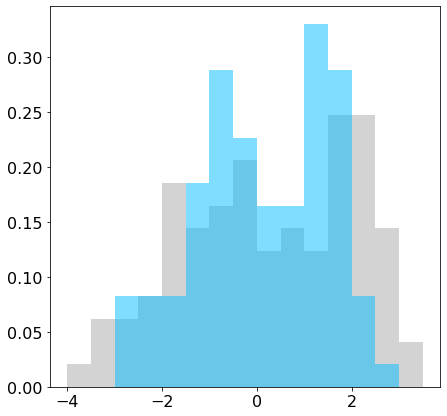

In [10]:
filename = "C:/Users/yq904481/research/repos/SIR_HUXt/data/out_data/ensemble_constraint_testing.hdf5"
out_file = h5py.File(filename, 'r')

n_truths = out_file['n_truths'][()]

err_pri = np.zeros(n_truths)
err_pos = np.zeros(n_truths)
for i in range(n_truths):
    
    truth_key = "truth_{:03d}".format(i)
    truth_grp = out_file[truth_key]
    
    arrival_tru = truth_grp['arrival_true']
    arrivals = truth_grp['arrivals']
    weights = truth_grp['weights']
    
    arrival_pri = np.average(arrivals)
    arrival_pos = np.average(arrivals, weights=weights)
    
    err_pri[i] = (arrival_pri - arrival_tru)*24
    err_pos[i] = (arrival_pos - arrival_tru)*24
    
out_file.close()
    
rmse_pri = np.sqrt(np.mean(err_pri**2))
rmse_pos = np.sqrt(np.mean(err_pos**2))
rmse_ratio = rmse_pri / rmse_pos

print("Arrival Prior RMSE={:3.2f}, Posterior RMSE={:3.2f}, Prior/Posterior={:3.2f}".format(rmse_pri, rmse_pos, rmse_ratio))
    
fig, ax = plt.subplots(figsize=(7, 7))
bins = np.arange(-4,4,0.5)
ax.hist(err_pri, bins, density=True, color='lightgrey', label='Prior', alpha=1.0)
ax.hist(err_pos, bins, density=True, color='deepskyblue', alpha=0.5, label='Posterior')

In [4]:
filename = "C:/Users/yq904481/research/repos/SIR_HUXt/data/out_data/ensemble_constraint_testing.hdf5"
out_file = h5py.File(filename, 'r')


n_truths = out_file['n_truths'][()]

out_file.close()


n_ensembles = out_file['n_ensembles'][()]
arrival_true = out_file['arrival_true'][()]
cme_truth_params = out_file['truth_cme_params'][()]
lon_true = cme_truth_params[0]*u.rad.to(u.deg)
if lon_true > 180:
    lon_true -= 360.0
lat_true = cme_truth_params[1]*u.rad.to(u.deg)
width_true = cme_truth_params[2]*u.rad.to(u.deg)
thick_true = cme_truth_params[4]*u.km.to(u.solRad)
speed_true = cme_truth_params[5]

truth_params = {'arrivals': arrival_true, 'speed':speed_true, 'lon':lon_true,
                'lat':lat_true, 'width':width_true, 'thickness': thick_true}

param_keys = truth_params.keys()

fig, ax = plt.subplots(2, 3, figsize=(8,8))
axr = ax.ravel()

for i, p_key in enumerate(param_keys):

    param_prior = np.zeros(n_ensembles)
    param_posterior = np.zeros(n_ensembles)
    
    for j in range(n_ensembles):
        
        ens_key = "ensemble_{:02d}".format(j)
        ens = out_file[ens_key]

        params = ens[p_key][()]
        weights = ens['weights'][()]        
        
        param_prior[j] = np.average(params)
        param_posterior[j] = np.average(params, weights=weights)
          
    truth = truth_params[p_key]    
    param_pri_avg = np.mean(param_prior)
    param_pos_avg = np.mean(param_posterior)
    
    param_pri_sem = st.sem(param_prior)
    param_pos_sem = st.sem(param_posterior)
    print('**************')
    print("{} Truth={:3.2f}, Prior={:3.2f}+/-{:3.2f}, Posterior={:3.2f}+/-{:3.2f}".format(p_key, truth, param_pri_avg, param_pri_sem, param_pos_avg, param_pos_sem))
    
    err_pri = param_prior - truth
    err_pos = param_posterior - truth
    rmse_pri = np.sqrt(np.mean(err_pri**2))
    rmse_pos = np.sqrt(np.mean(err_pos**2))
    rmse_ratio = rmse_pri/rmse_pos
    print("{} Prior RMSE={:3.2f}, Posterior RMSE={:3.2f}, Prior/Posterior={:3.2f}".format(p_key, rmse_pri, rmse_pos, rmse_ratio))

In [3]:
np.random.seed(20200114)

# Set up HUXt with Uniform wind. 
start_time = Time('2008-01-01T00:00:00')
model = setup_huxt(start_time, uniform_wind=True)

# Initialise Earth directed CME. Coords in HEEQ, so need Earth Lat.
ert = model.get_observer('EARTH')
avg_ert_lat = np.mean(ert.lat.to(u.deg).value)
cme_base = get_base_cme(v=1000, lon=0, lat=avg_ert_lat, width=35, thickness=1)

# Perturb the base CME to get a "Truth" CME, and solve
cme_truth = perturb_cone_cme(cme_base)
model.solve([cme_truth])
cme_truth = model.cmes[0]

# Setup an observer at ~L5.
observer_lon = -60*u.deg
observer = Observer(model, observer_lon, el_min=4.0, el_max=40.0)
cme_truth_obs = observer.compute_synthetic_obs(el_spread=0.5, cadence=3, el_min=observer.el_min, el_max=observer.el_max)
#animate_observer(model, observer, 'ensemble_constraint_fixed_truth_fixed_obs', add_flank=True, add_fov=True)
    
# Now produce dataset of different ensemble runs, with varying observations.
n_ensembles = 25
n_members = 50

filename = "ensemble_constraint_fixed_truth_fixed_obs.hdf5"
out_file = create_analysis_output_file(filename)

# Store the base and truth cme paramters, and tracked flanks etc.
out_file.create_dataset('n_ensembles', data=n_ensembles)
cme_params = get_cme_params_for_sir(cme_base)
out_file.create_dataset('base_cme_params', data=cme_params)
cme_params = get_cme_params_for_sir(cme_truth)
out_file.create_dataset('truth_cme_params', data=cme_params)
out_file.create_dataset('true_model_flank', data=observer.model_flank.values)
out_file.create_dataset('true_observed_flank', data=cme_truth_obs.values)
out_file.create_dataset('true_arrival', data=cme_truth.earth_arrival_time.jd)

for i in range(n_ensembles):
    
    ens_key = 'ensemble_{:02d}'.format(i)
    print("{} - {}".format(ens_key, pd.datetime.now().time()))
    ensgrp = out_file.create_group(ens_key)
    ensgrp.create_dataset('n_members', data=n_members)
    
    weights = np.zeros(n_members)
    arrivals = np.zeros(n_members)
    speed = np.zeros(n_members)
    lon = np.zeros(n_members)
    lat = np.zeros(n_members)
    width = np.zeros(n_members)     
    thickness = np.zeros(n_members)
    
    for j in range(n_members):
    
        # Perturb the CME and solve
        cme_ens = perturb_cone_cme(cme_base)
        model.solve([cme_ens])
        cme_ens = model.cmes[0]

        ens_observer = Observer(model, observer_lon, el_min=4.0, el_max=40.0)

        # Compute RMSE between ens_observer model flank and truth observations
        profile_rms, n_samp = compute_profile_difference(cme_truth_obs, ens_observer.model_flank)
        
        weights[j] = 1.0/profile_rms
        arrivals[j] = cme_ens.earth_arrival_time.jd
        speed[j] = cme_ens.v.value
        lon[j] = cme_ens.longitude.to(u.deg).value
        lat[j] = cme_ens.latitude.to(u.deg).value
        width[j] = cme_ens.width.to(u.deg).value
        thickness[j] = cme_ens.thickness.value

        # Stash this CMEs parameters, observed flank, and arrival time
        memgrp = ensgrp.create_group('member_{:02d}'.format(j))
        cme_params = np.array([arrivals[j], speed[j], lon[j], lat[j], width[j], thickness[j]])
        memgrp.create_dataset('cme_params', data=cme_params)
        memgrp.create_dataset('model_flank', data=ens_observer.model_flank.values)
        memgrp.create_dataset('profile_rms', data=profile_rms)
        memgrp.create_dataset('n_rms_samples', data=n_samp)
        memgrp.create_dataset('weight', data=weights[j])
    
    # Normalise weights and force longitude onto -180:180 domain (better for histogramming)
    weights_norm = weights / np.sum(weights)
    lon[lon > 180.0] -= 360.0
    
    # Now save the ensemble arrays for each parameter    
    ensgrp.create_dataset('weights', data=weights_norm)
    ensgrp.create_dataset('arrivals', data=arrivals)
    ensgrp.create_dataset('speed', data=speed)
    ensgrp.create_dataset('lon', data=lon)
    ensgrp.create_dataset('lat', data=lat)
    ensgrp.create_dataset('width', data=width)
    ensgrp.create_dataset('thickness', data=thickness)
        
    #out_file.flush()

out_file.close()    

Files already exist for CR2065
ensemble_00 - 12:22:02.565924
ensemble_01 - 12:24:11.187020
ensemble_02 - 12:26:07.603001
ensemble_03 - 12:27:55.452776
ensemble_04 - 12:29:43.571976
ensemble_05 - 12:31:34.527591
ensemble_06 - 12:33:23.200916
ensemble_07 - 12:35:12.107397
ensemble_08 - 12:37:02.442669
ensemble_09 - 12:38:51.302230
ensemble_10 - 12:40:40.808301
ensemble_11 - 12:42:31.990615
ensemble_12 - 12:44:20.495366
ensemble_13 - 12:46:10.796869
ensemble_14 - 12:48:00.123701
ensemble_15 - 12:49:48.150896
ensemble_16 - 12:51:38.995109
ensemble_17 - 12:53:27.344239
ensemble_18 - 12:55:16.847615
ensemble_19 - 12:57:06.822528
ensemble_20 - 12:58:55.679911
ensemble_21 - 13:00:44.338250
ensemble_22 - 13:02:33.368583
ensemble_23 - 13:04:21.607483
ensemble_24 - 13:06:10.525410


In [9]:
def plot_arrival_dist(i, arrivals, weights, arrival_tru):

    arrivals = Time(np.array(arrivals),format='jd')

    arrival_tru = Time(arrival_tru, format='jd')
    window = 5.0/24
    dt = 1.0/24
    bins = np.arange((arrival_tru - window).jd, (arrival_tru + window+dt).jd, dt)
    bins = Time(bins, format='jd')

    fig, ax = plt.subplots(figsize=(7,7))
    ax.hist(arrivals.datetime, bins.datetime, density=True, color='lightgrey', label='Prior', alpha=1.0)
    ax.hist(arrivals.datetime, bins.datetime, density=True, weights=weights, color='deepskyblue', alpha=0.5, label='Posterior')
    ax.vlines(arrival_tru.datetime, 0,10,'r')

    ax.set_xlabel('CME arrival time (day-hour)')
    hours = mpl.dates.HourLocator(interval=4)   # every hour
    hours_fmt = mpl.dates.DateFormatter('%d-%H')
    # format the ticks
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(hours_fmt)

    ax.set_ylabel('Frequency')
    ax.legend()
    figname = "arrival_hist_ensemble_{:02d}.png".format(i)
    fig.savefig(figname)
    plt.close('all')
    return

**************
arrivals Truth=2454469.15, Prior=2454469.00+/-0.00, Posterior=2454469.02+/-0.00
arrivals Prior RMSE=0.15, Posterior RMSE=0.12, Prior/Posterior=1.22
**************
speed Truth=942.55, Prior=999.22+/-1.78, Posterior=992.20+/-1.85
speed Prior RMSE=57.34, Posterior RMSE=50.47, Prior/Posterior=1.14
**************
lon Truth=-4.95, Prior=0.04+/-0.18, Posterior=0.08+/-0.20
lon Prior RMSE=5.07, Posterior RMSE=5.13, Prior/Posterior=0.99
**************
lat Truth=-10.11, Prior=-3.28+/-0.19, Posterior=-3.44+/-0.23
lat Prior RMSE=6.89, Posterior RMSE=6.77, Prior/Posterior=1.02
**************
width Truth=25.23, Prior=35.00+/-0.16, Posterior=33.31+/-0.17
width Prior RMSE=9.79, Posterior RMSE=8.12, Prior/Posterior=1.21
**************
thickness Truth=1.51, Prior=1.01+/-0.02, Posterior=0.99+/-0.02
thickness Prior RMSE=0.51, Posterior RMSE=0.52, Prior/Posterior=0.98


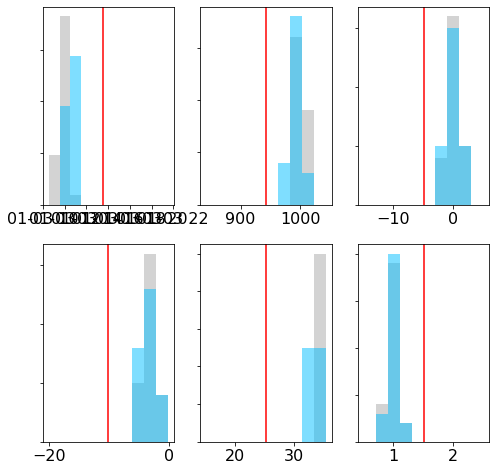

In [37]:
def plot_param_dist(ax, p_key, truth, param_prior, param_posterior):
    
    if p_key == 'arrivals':
        window = 5.0/24
        dw = 1.0/24
    elif p_key == 'speed':
        window=100
        dw = 20
    elif p_key == 'lon':
        window=10
        dw = 2
    elif p_key == 'lat':
        window=10
        dw = 2
    elif p_key == 'width':
        window=10
        dw = 2
    elif p_key == 'thickness':
        window=1
        dw = 0.2
    
    bins = np.arange(truth-window,truth+window+dw,dw)
    if p_key == 'arrivals':
        truth = Time(truth, format='jd')
        bins = Time(bins, format='jd')
        param_prior = Time(param_prior, format='jd')
        param_posterior = Time(param_posterior, format='jd')
        ax.hist(param_prior.datetime, bins.datetime, density=True, color='lightgrey', label='Prior', alpha=1.0)
        ax.hist(param_posterior.datetime, bins.datetime, density=True, color='deepskyblue', alpha=0.5, label='Posterior')
        ylims = ax.get_ylim()
        ax.vlines(truth.datetime, 0, ylims[1], 'r')
        ax.set_ylim(ylims)
    else:
        ax.hist(param_prior, bins, density=True, color='lightgrey', label='Prior', alpha=1.0)
        ax.hist(param_posterior, bins, density=True, color='deepskyblue', alpha=0.5, label='Posterior')
        ylims = ax.get_ylim()
        ax.vlines(truth, 0, ylims[1], 'r')
        ax.set_ylim(ylims)
    return ax

filename = "C:/Users/yq904481/research/repos/SIR_HUXt/data/out_data/ensemble_constraint_fixed_truth_fixed_obs.hdf5"
out_file = h5py.File(filename, 'r')

n_ensembles = out_file['n_ensembles'][()]
arrival_true = out_file['true_arrival'][()]
cme_truth_params = out_file['truth_cme_params'][()]
lon_true = cme_truth_params[1]*u.rad.to(u.deg)
if lon_true > 180:
    lon_true -= 360.0
lat_true = cme_truth_params[2]*u.rad.to(u.deg)
width_true = cme_truth_params[3]*u.rad.to(u.deg)
speed_true = cme_truth_params[4]
thick_true = cme_truth_params[5]*u.km.to(u.solRad)

truth_params = {'arrivals': arrival_true, 'speed':speed_true, 'lon':lon_true,
                'lat':lat_true, 'width':width_true, 'thickness': thick_true}

param_keys = truth_params.keys()

fig, ax = plt.subplots(2, 3, figsize=(8,8))
axr = ax.ravel()

for i, p_key in enumerate(param_keys):

    param_prior = np.zeros(n_ensembles)
    param_posterior = np.zeros(n_ensembles)
    
    for j in range(n_ensembles):
        
        ens_key = "ensemble_{:02d}".format(j)
        ens = out_file[ens_key]

        params = ens[p_key][()]
        weights = ens['weights'][()]        
        
        param_prior[j] = np.average(params)
        param_posterior[j] = np.average(params, weights=weights)
          
    truth = truth_params[p_key]    
    param_pri_avg = np.mean(param_prior)
    param_pos_avg = np.mean(param_posterior)
    
    param_pri_sem = st.sem(param_prior)
    param_pos_sem = st.sem(param_posterior)
    print('**************')
    print("{} Truth={:3.2f}, Prior={:3.2f}+/-{:3.2f}, Posterior={:3.2f}+/-{:3.2f}".format(p_key, truth, param_pri_avg, param_pri_sem, param_pos_avg, param_pos_sem))
    
    err_pri = param_prior - truth
    err_pos = param_posterior - truth
    rmse_pri = np.sqrt(np.mean(err_pri**2))
    rmse_pos = np.sqrt(np.mean(err_pos**2))
    rmse_ratio = rmse_pri/rmse_pos
    print("{} Prior RMSE={:3.2f}, Posterior RMSE={:3.2f}, Prior/Posterior={:3.2f}".format(p_key, rmse_pri, rmse_pos, rmse_ratio))
    
    plot_param_dist(axr[i], p_key, truth, param_prior, param_posterior)

out_file.close()

for a in axr:
    a.set_yticklabels([])
    
    
